# Centroid-based samplinig of data

**NOTE: THIS APPROACH WAS SHOWN TO BE SUBOPTIMAL IN greg-dimension-reduction-xgboost.ipynb, Experiment 1 and is therefore no longer used**

Here we use the the dataset that was stitched toghether in the _greg-features_ notebook. We need to do this otherwise some drugs would be overrepresented in the training data and therefore any models are more likely to overfit accordingly.

Our approach is to more fairly represent each drug. For each cluster (or vertical) of PIDs (proteins) associated with a CID (drug/molecule), we find the centroid (mean) and then find the entry closest to that. We also then find the furthest entry from the centroid. We do this for acttive and inactive interactions and therefore have a maximum of four data points for any given CID (two for active and two for inactive). By taking the centroid we aim to take an approximately _typical_ exemplar PID for the CID; by also taking the furthest from the exemplar we aim to introduce some differentiating protein characteristics to help train the model.

* in cid-pid space, for each active cid set:
    1. retain the closest point to the centroid (the mean of the pid vectors for a given cid)
    1. retain the furthest point from the centroid
* in cid-pid space, for each inactive cid set:
    1. retain the closest point to the centroid
    1. retain the furthest point from the centroid
* balance the set according to number of active and inactive transitions by add/removing samples

<hr>
We assume the data (**features.h5**, the full feature set) is in a sub-directory of the **/data** folder. I've already added entries to the _.gitignore_ file so that they won't be committed to the repository. Note that this file should be updated for new versions of the data.

See the [data readme in the Gitbug repository](https://github.com/BrianDavisMath/FDA-COVID19/tree/master/data) for more details.

<hr>

In [1]:
%pylab inline
%autosave 25

import h5py
import random
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


## Data location

Change this when you get a new data set.

In [2]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

## Load the data from features.h5
<hr>

In [3]:
store = pd.HDFStore(data_loc + 'training_features.h5')
df_features = pd.DataFrame(store['df' ]).drop('sample_activity_score', axis=1)
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))
store.close()

rows: 163,926, columns: 17,076


## Group

#### Group by cid and activity so we can find the centroid and furthest from the centroid in each group

In [4]:
df_grouped = df_features.groupby(['cid', 'activity'])

# Look at the group ("vertical") for cid 204 with active interactions.
df_grouped.get_group((204, 1))

,cid,pid,activity,AEK,VEL,EKF,LGM,VKN,LKP,NEE,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
19955,204,P0C6X7,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,2.367871,...,0,0,0,0,0,0,0,0,0,0
19956,204,P57771,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
19957,204,Q8TCT1,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
19958,204,O75388,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
19959,204,P26447,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
19960,204,BAA01595,1,0.773381,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
19961,204,Q9UM07,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
19962,204,AAB59829,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
19963,204,P9WIQ1,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
19964,204,Q99VQ4,1,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0


## Get the representative CIDs

Note that were basing this on the full data set, including the cid vectors. 

A performance improvement would be to use data based on the merging of the interactions (cid, pid, activity) data and the protein data only and therefore reduce the dimensionality when measuring distances, i.e. not include cid features.

In [5]:
def get_representative_cid_indices(df_group):
    # remove cid, pid and activity
    df_group.drop(['cid', 'pid', 'activity'],axis=1,inplace=True)
    
    centroid = df_group.mean().values
    distances = np.sqrt((np.square(df_group.values[:,np.newaxis]-centroid).sum(axis=2)))

    idx = df_group.index
    closest_idx_to_centroid = idx[distances.argmin()]
    furthest_idx_to_centroid = idx[distances.argmax()]
    
    return [closest_idx_to_centroid, furthest_idx_to_centroid]

In [6]:
from IPython.display import display, clear_output

num_groups = len(df_grouped.groups)
print('num groups: {:,}.'.format(num_groups))

indices = []
i = 1
for (cid, activity), group in df_grouped:
    indices.append(get_representative_cid_indices(group))
    clear_output(wait=True)
    display('processed cid group {:,} of {:,}'.format(i, num_groups))
    i = i + 1

indices = np.unique(np.array(indices).flatten())

len(indices)

'processed cid group 84,978 of 84,978'

98368

### Save indices to file

Tos save us running the above long-running operation again.

In [7]:
indices = np.array(indices)
h5f = h5py.File(data_loc+'indices.h5', 'w')
h5f.create_dataset('dataset_1', data=indices)
h5f.close()

# test reload from file
h5f = h5py.File(data_loc+'indices.h5','r')
b = h5f['dataset_1'][:]
h5f.close()

assert(np.allclose(indices, b)) # check our retrieved indices are the same

### Check balance of active vs inactive

In [8]:
cids = df_features[df_features.index.isin(indices)]
grouped = cids.groupby('cid')['activity'].value_counts()
df_grouped = grouped.to_frame()
df_grouped.rename(columns={'activity': "activity_count"}, inplace=True)
df_grouped_stacked = df_grouped.unstack()
df_grouped_stacked.fillna(0, inplace=True)
df_grouped_stacked = df_grouped_stacked['activity_count']
df_grouped_stacked = df_grouped_stacked.reset_index()
df_grouped_stacked.rename_axis('', axis=1, inplace=True)

z = df_grouped_stacked[df_grouped_stacked[1] == 0]
nz = df_grouped_stacked[df_grouped_stacked[1] > 0]
print('there are {:,} drugs with zero activation'.format(len(z)))
print('there are {:,} drugs with an activation'.format(len(nz)))

there are 75,307 drugs with zero activation
there are 7,570 drugs with an activation


### Remove indices with no active label

In [9]:
rows_to_remove = df_grouped_stacked[df_grouped_stacked[1] == 0]['cid'].values.tolist()
del df_features
df_features = cids[~cids['cid'].isin(rows_to_remove)]
print(len(df_features))
df_features.head()

13221


,cid,pid,activity,AEK,VEL,EKF,LGM,VKN,LKP,NEE,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,204106,Q9UP65,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
1,204106,P47712,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
3,10290302,P00403,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
4,10290302,P00395,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
7,46938678,O15528,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0


### Balance

In [10]:
# Add some of the inactive rows back in to balance the classes.

num_to_add = len(df_features) - len(nz)
print('adding {:,} inactive rows'.format(num_to_add))

rows_to_add = random.sample(rows_to_remove, num_to_add)
df_add = cids[cids['cid'].isin(rows_to_add)]

df_features = df_features.append(df_add)

print(len(df_features))
df_features.head()

adding 5,651 inactive rows
19632


,cid,pid,activity,AEK,VEL,EKF,LGM,VKN,LKP,NEE,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,204106,Q9UP65,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
1,204106,P47712,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
3,10290302,P00403,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
4,10290302,P00395,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0
7,46938678,O15528,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0,0,0,0,0,0,0,0,0,0


### Distribution of sampled CIDs

total number of cid-pid rows: 19,632
number of features: 17,076

there are 5,651 drugs with zero activation
there are 7,570 drugs with an activation
there are 5,469 drugs with only an activation



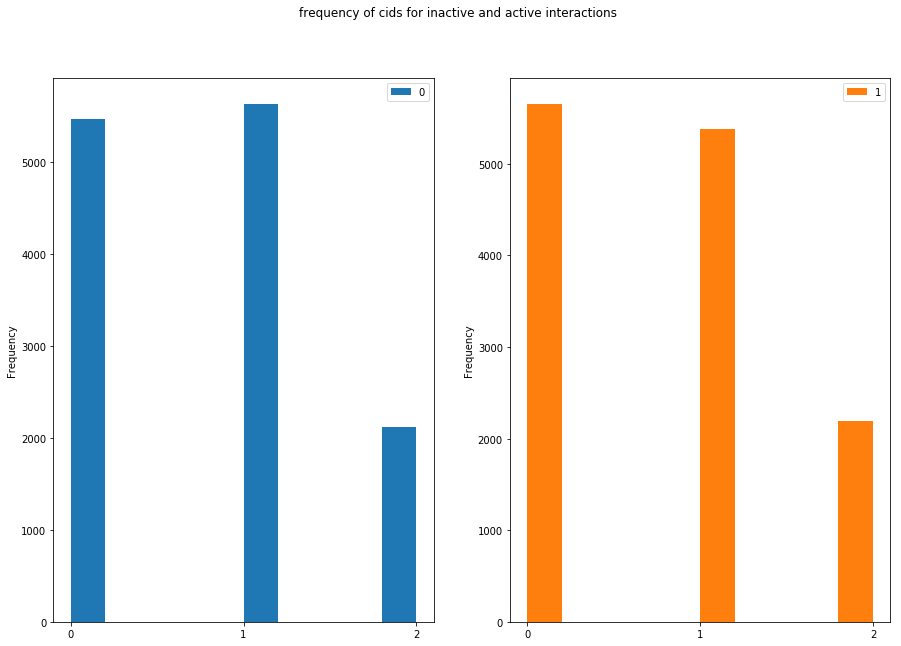

In [11]:
grouped = df_features.groupby('cid')['activity'].value_counts()
df_grouped = grouped.to_frame()
df_grouped.rename(columns={'activity': "activity_count"}, inplace=True)
df_grouped_stacked = df_grouped.unstack()
df_grouped_stacked.fillna(0, inplace=True)
df_grouped_stacked = df_grouped_stacked['activity_count']
df_grouped_stacked = df_grouped_stacked.reset_index()
df_grouped_stacked.rename_axis('', axis=1, inplace=True)
df_grouped_stacked.head()

axes = df_grouped_stacked[[0, 1]].plot(kind = 'hist', subplots=True, layout = (1, 2), 
  title="frequency of cids for inactive and active interactions",
  figsize=(15, 10), xticks=[0, 1, 2], )

print('total number of cid-pid rows: {:,}'.format(len(df_features)))
print('number of features: {:,}\n'.format(len(df_features.columns)))

z = df_grouped_stacked[df_grouped_stacked[1] == 0]
nz = df_grouped_stacked[df_grouped_stacked[1] > 0]
onz = df_grouped_stacked[(df_grouped_stacked[1] > 0) & (df_grouped_stacked[0] == 0)]
print('there are {:,} drugs with zero activation'.format(len(z)))
print('there are {:,} drugs with an activation'.format(len(nz)))
print('there are {:,} drugs with only an activation\n'.format(len(onz)))

### Distribution of PIDs within sample

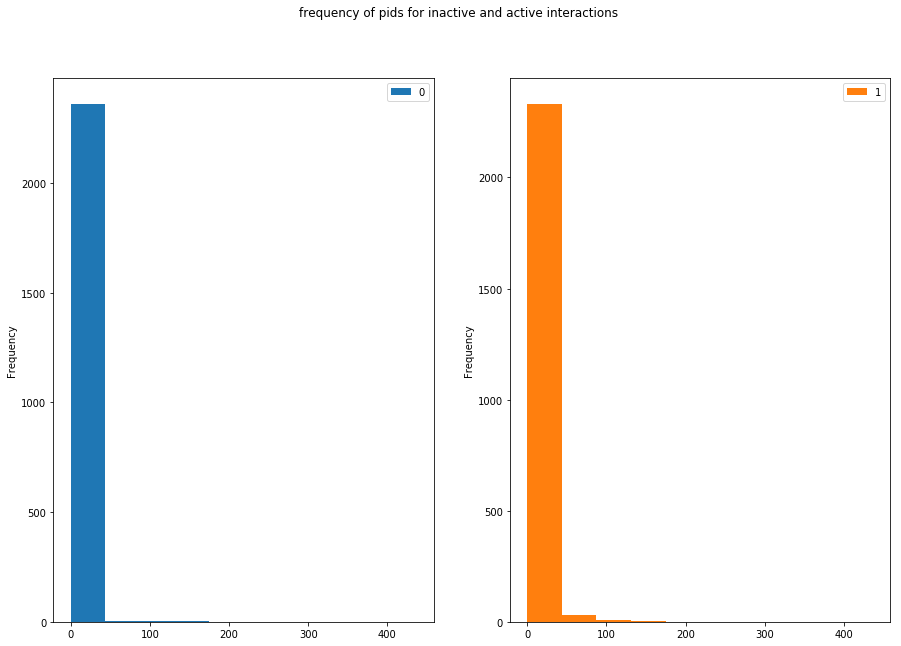

In [12]:
del df_grouped_stacked
grouped = df_features.groupby('pid')['activity'].value_counts()
df_grouped = grouped.to_frame()
df_grouped.rename(columns={'activity': "activity_count"}, inplace=True)
df_grouped_stacked = df_grouped.unstack()
df_grouped_stacked.fillna(0, inplace=True)
df_grouped_stacked = df_grouped_stacked['activity_count']
df_grouped_stacked = df_grouped_stacked.reset_index()
df_grouped_stacked.rename_axis('', axis=1, inplace=True)

axes = df_grouped_stacked[[0, 1]].plot(kind = 'hist', subplots=True, layout = (1, 2), 
  title="frequency of pids for inactive and active interactions",
  figsize=(15, 10))

## Drop zero-variance columns

Zero-variance columns provide no value to the model.

In [13]:
var_cols = [col for col in df_features.columns if df_features[col].nunique() > 1]
df_novar_cols_dropped = df_features[var_cols].copy()

print('Dropped {:,} columns that have zero variance.'.format(len(df_features.columns)-len(var_cols)))
print('rows: {:,}, columns: {:,}'.format(len(df_novar_cols_dropped), len(df_novar_cols_dropped.columns)))

Dropped 705 columns that have zero variance.
rows: 19,632, columns: 16,371


### Save data to file

In [14]:
store = pd.HDFStore(data_loc + 'training_sampled_data.h5')
store['df'] = df_novar_cols_dropped
store.close()